In [21]:
from __future__ import print_function

import sys
import os
import pandas as pd
import numpy as np

from keras.layers import Input, Embedding, LSTM, TimeDistributed, Dense
from keras.models import Model, load_model

# To import 'katakana' from relative path
sys.path.append(os.path.abspath(os.path.join('..')))
from katakana import encoding

INPUT_LENGTH = 20
OUTPUT_LENGTH = 20


# Data pre-processing

In [22]:
data = pd.read_csv('../data/joined_titles.csv', header=None)
data = data.sample(frac=1, random_state=0)

data_input = [s.decode('utf-8').lower() for s in data[0]]
data_output = [s.decode('utf-8') for s in data[1]]
print(data_input[0], data_output[0])
print(data_input[5], data_output[5])

data_size = len(data)

# We will use the first 0-60th %-tile (60%) of data for the training
training_input  = data_input[data_size*0/100:data_size*60/100]
training_output = data_output[data_size*0/100:data_size*60/100]

# We will use the first 60-70th %-tile (10%) of data for the training
validation_input = data_input[data_size*60/100:data_size*70/100]
validation_output = data_output[data_size*60/100:data_size*70/100]

print('training size', len(training_input))
print('validation size', len(validation_input))

dorogobuzh ドロゴブージ
brian cowen ブライアン・カウエン
training size 64356
validation size 10726


### Transform data into Numpy arrays

We transform the sequences of characters into sequences of integer IDs. This will be done by using pre-written functions in `encoding` module. 
- First, `encoding.build_characters_encoding` will build encoding/decoding dictionary from the data. 
- Then, `encoding.transform` will transform the data into numpy array.

Check [the previous notebook](./Writing Katakana using Sequence-to-Sequence in Keras) for the details about the transformation.

In [23]:
input_encoding, input_decoding, input_dict_size = encoding.build_characters_encoding(data_input)
output_encoding, output_decoding, output_dict_size = encoding.build_characters_encoding(data_output)

print('English character dict size:', input_dict_size)
print('Katakana character dict size:', output_dict_size)

encoded_training_input = encoding.transform(
    input_encoding, training_input, vector_size=INPUT_LENGTH)
encoded_training_output = encoding.transform(
    output_encoding, training_output, vector_size=OUTPUT_LENGTH)

print('encoded_training_input', encoded_training_input.shape)
print('encoded_training_output', encoded_training_output.shape)

encoded_validation_input = encoding.transform(
    input_encoding, validation_input, vector_size=INPUT_LENGTH)
encoded_validation_output = encoding.transform(
    output_encoding, validation_output, vector_size=OUTPUT_LENGTH)

print('encoded_validation_input', encoded_validation_input.shape)
print('encoded_validation_output', encoded_validation_output.shape)

English character dict size: 54
Katakana character dict size: 89
encoded_training_input (64356, 20)
encoded_training_output (64356, 20)
encoded_validation_input (10726, 20)
encoded_validation_output (10726, 20)


# Sequence-to-Sequence in Keras

In [24]:
encoder_input = Input(shape=(INPUT_LENGTH,))
decoder_input = Input(shape=(OUTPUT_LENGTH,))

### Encoder / Decoder

In [25]:
from keras.layers import SimpleRNN

encoder = Embedding(input_dict_size, 64, input_length=INPUT_LENGTH, mask_zero=True)(encoder_input)
encoder = LSTM(64, return_sequences=True, unroll=True)(encoder)
encoder_last = encoder[:,-1,:]

print('encoder', encoder)
print('encoder_last', encoder_last)

decoder = Embedding(output_dict_size, 64, input_length=OUTPUT_LENGTH, mask_zero=True)(decoder_input)
decoder = LSTM(64, return_sequences=True, unroll=True)(decoder, initial_state=[encoder_last, encoder_last])

print('decoder', decoder)

encoder Tensor("lstm_5/transpose_2:0", shape=(?, 20, 64), dtype=float32)
encoder_last Tensor("strided_slice_2:0", shape=(?, 64), dtype=float32)
decoder Tensor("lstm_6/transpose_2:0", shape=(?, 20, 64), dtype=float32)


### Attention Mechanism

Reference: 
[Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/pdf/1508.04025.pdf)'s 
**Global Attention** with **Dot**-based scoring function (Section 3, 3.1)


In [26]:
from keras.layers import Activation, dot, concatenate

scores = dot([decoder, encoder], axes=[2, 2])
attention = Activation('softmax')(scores)
print('attention', attention)

context = dot([attention, encoder], axes=[2,1])
print('context', context)

#
decoder_combined_context = concatenate([context, decoder])
decoder_combined_context = TimeDistributed(Dense(64, activation="linear"))(decoder_combined_context)
print('decoder_combined_context', decoder_combined_context)

decoder_output = TimeDistributed(Dense(output_dict_size, activation="softmax"))(decoder_combined_context)
print('decoder_output', decoder_output)


attention Tensor("activation_3/div:0", shape=(?, 20, 20), dtype=float32)
context Tensor("dot_6/MatMul:0", shape=(?, 20, 64), dtype=float32)
decoder_combined_context Tensor("time_distributed_5/Reshape_1:0", shape=(?, 20, 64), dtype=float32)
decoder_output Tensor("time_distributed_6/Reshape_1:0", shape=(?, 20, 89), dtype=float32)


In [27]:
model = Model(inputs=[encoder_input, decoder_input], outputs=[decoder_output])
model.compile(optimizer='adam', loss='binary_crossentropy')

## Training the model

In [28]:
training_encoder_input = encoded_training_input
training_decoder_input = np.zeros_like(encoded_training_output)
training_decoder_input[:, 1:] = encoded_training_output[:,:-1]
training_decoder_input[:, 0] = encoding.CHAR_CODE_START
training_decoder_output = np.eye(output_dict_size)[encoded_training_output.astype('int')]

validation_encoder_input = encoded_validation_input
validation_decoder_input = np.zeros_like(encoded_validation_output)
validation_decoder_input[:, 1:] = encoded_validation_output[:,:-1]
validation_decoder_input[:, 0] = encoding.CHAR_CODE_START
validation_decoder_output = np.eye(output_dict_size)[encoded_validation_output.astype('int')]

In [29]:
if os.path.isfile('model.h5'):
    model = load_model('model.h5')
else:
    model.fit(x=[training_encoder_input, training_decoder_input], y=[training_decoder_output],
          validation_data=([validation_encoder_input, validation_decoder_input], [validation_decoder_output]),
          verbose=2, batch_size=64, epochs=30)

model.fit(x=[training_encoder_input, training_decoder_input], y=[training_decoder_output],
          validation_data=([validation_encoder_input, validation_decoder_input], [validation_decoder_output]),
          verbose=2, batch_size=64, epochs=5)

model.save('model.h5')

Train on 64356 samples, validate on 10726 samples
Epoch 1/30
90s - loss: 0.0456 - val_loss: 0.0385
Epoch 2/30
85s - loss: 0.0307 - val_loss: 0.0231
Epoch 3/30
84s - loss: 0.0204 - val_loss: 0.0186
Epoch 4/30
89s - loss: 0.0178 - val_loss: 0.0171
Epoch 5/30
85s - loss: 0.0165 - val_loss: 0.0162
Epoch 6/30
89s - loss: 0.0156 - val_loss: 0.0154
Epoch 7/30
95s - loss: 0.0149 - val_loss: 0.0151
Epoch 8/30
93s - loss: 0.0144 - val_loss: 0.0145
Epoch 9/30
96s - loss: 0.0140 - val_loss: 0.0141
Epoch 10/30
98s - loss: 0.0136 - val_loss: 0.0138
Epoch 11/30
97s - loss: 0.0133 - val_loss: 0.0136
Epoch 12/30
97s - loss: 0.0131 - val_loss: 0.0134
Epoch 13/30
98s - loss: 0.0129 - val_loss: 0.0134
Epoch 14/30
97s - loss: 0.0127 - val_loss: 0.0132
Epoch 15/30
99s - loss: 0.0125 - val_loss: 0.0130
Epoch 16/30
94s - loss: 0.0123 - val_loss: 0.0130
Epoch 17/30
93s - loss: 0.0122 - val_loss: 0.0129
Epoch 18/30
93s - loss: 0.0121 - val_loss: 0.0127
Epoch 19/30
95s - loss: 0.0119 - val_loss: 0.0127
Epoch 20/

/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py:2337: UserWarning: Layer lstm_6 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'strided_slice_2:0' shape=(?, 64) dtype=float32>, <tf.Tensor 'strided_slice_2:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


### Testing the model


In [33]:
def generate(text):
    encoder_input = encoding.transform(input_encoding, [text.lower()], 20)
    decoder_input = np.zeros(shape=(len(encoder_input), OUTPUT_LENGTH))
    decoder_input[:,0] = encoding.CHAR_CODE_START
    for i in range(1, OUTPUT_LENGTH):
        output = model.predict([encoder_input, decoder_input]).argmax(axis=2)
        decoder_input[:,i] = output[:,i]
    return decoder_input[:,1:]

def decode(decoding, sequence):
    text = ''
    for i in sequence:
        if i == 0:
            break
        text += output_decoding[i]
    return text

def to_katakana(text):
    decoder_output = generate(text)
    return decode(output_decoding, decoder_output[0])


common_american_names = ['James', 'John', 'Robert', 'Mary', 'Patricia', 'Linda']
for name in common_american_names:
    print(name, to_katakana(name))

James ジェームズ
John ジョン
Robert ロバート
Mary マリー
Patricia パトリシア
Linda リンダ


In [35]:
 print(to_katakana('Peter'))

ペーター


In [159]:
print(to_katakana('Banana'))

バナーナ


In [190]:
print(model.inputs)
print(model.layers[7])

attention_layer = model.layers[7]
attention_model = Model(inputs=model.inputs, outputs=[attention_layer.output])


testing_input_word = training_input[199]
testing_output_word = training_output[199]


testing_encoder_input = encoding.transform(input_encoding, [testing_input_word.lower()], INPUT_LENGTH)
testing_decoder_input = np.zeros_like(encoded_training_output)
testing_decoder_input[:, 1:] = encoding.transform(output_encoding, [testing_output_word.lower()], OUTPUT_LENGTH -1)
testing_decoder_input[:, 0] = encoding.CHAR_CODE_START

attention_density = attention_model.predict([
    testing_encoder_input,
    testing_decoder_input,
])[0]

print(attention_density.shape)

attention_density = attention_density[:len(testing_output_word)+2, :len(testing_input_word)+2]

[<tf.Tensor 'input_5:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'input_6:0' shape=(?, 20) dtype=float32>]
(20, 20)


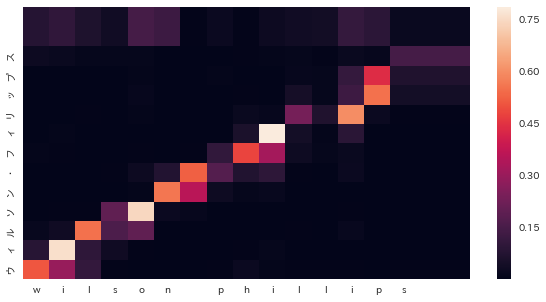

In [191]:
import matplotlib.pyplot as plt
import seaborn

plt.clf()
plt.figure(figsize=(10,5))
seaborn.set(font='TakaoPGothic')
ax = seaborn.heatmap(attention_density, 
                xticklabels=[w for w in testing_input_word],
                yticklabels=[w for w in testing_output_word])

ax.invert_yaxis()
plt.show()